# Example notebook

In this notebook we give some examples for running the forward and inverse model

In [114]:
#import libraries

In [115]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import random

import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import joblib
import pickle
import glob

from sklearn.metrics import mean_absolute_error
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import MinMaxScaler

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from sklearn import metrics

# define a quick function for mean relative absolute error
def mean_relative_absolute_error(y_true, y_pred):
    x=sum(np.abs((y_true - y_pred)) / y_true ) /len(y_true)
    return x

In [116]:
from tensorflow import keras
from tensorflow.keras.layers import *


from tensorflow.keras.models import Sequential

In [117]:
#import data and preprocess

### Lets import two spectra that the model did not trained on:

In [118]:
#read the data with pandas and convert to a dataframe
df_example_1 = pd.read_csv("data/Test model data/extra_04.txt", sep = " ",skiprows=1,header = None,delimiter=r"\s+",names = ['h','top','base','wavelength','Reflectance'])

Text(0.5, 1.0, 'heldout example 1')

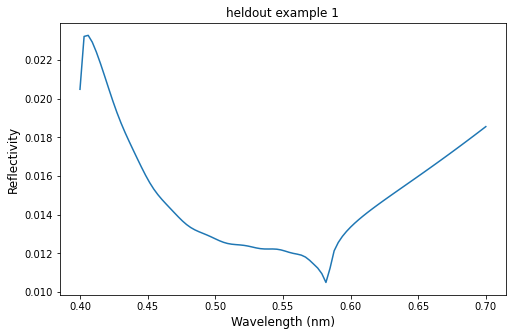

In [119]:
a4_dims = (8, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(ax=ax,data=df_example_1, x="wavelength", y='Reflectance')
plt.ylabel('Reflectivity',fontsize=12)
plt.xlabel('Wavelength (nm)',fontsize=12)
plt.title('heldout example 1')

In [120]:
#convert to nanometers:
df_example_1['h'] = df_example_1['h']* 10**9
df_example_1['top'] = df_example_1['top']* 10**9
df_example_1['base'] = df_example_1['base']* 10**9
df_example_1['wavelength'] = df_example_1['wavelength']* 10**3

df_example_1['base'] = df_example_1['base'] + df_example_1['top']

In [121]:
df_example_1.iloc[0]

h              151.00000
top             45.00000
base            60.00000
wavelength     400.00000
Reflectance      0.02049
Name: 0, dtype: float64

In [122]:
df_example_2 = pd.read_csv("data/Test model data/extra_05.txt", sep = " ",skiprows=1,header = None,delimiter=r"\s+",names = ['h','top','base','wavelength','Reflectance'])

Text(0.5, 1.0, 'heldout example 2')

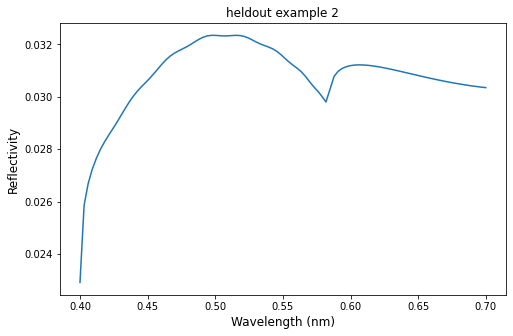

In [123]:
a4_dims = (8, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(ax=ax,data=df_example_2, x="wavelength", y='Reflectance')
plt.ylabel('Reflectivity',fontsize=12)
plt.xlabel('Wavelength (nm)',fontsize=12)
plt.title('heldout example 2')

In [124]:
#convert to nanometers:
df_example_2['h'] = df_example_2['h']* 10**9
df_example_2['top'] = df_example_2['top']* 10**9
df_example_2['base'] = df_example_2['base']* 10**9
df_example_2['wavelength'] = df_example_2['wavelength']* 10**3

df_example_2['base'] = df_example_2['base'] + df_example_2['top']

In [125]:
df_example_2.iloc[0]

h              182.000000
top             34.000000
base            50.000000
wavelength     400.000000
Reflectance      0.022918
Name: 0, dtype: float64

## Forward model inference

In [133]:
#load scaler and model
forward_scaler = joblib.load('./minmaxscalers/forward_scaler.save')
forward_model = keras.models.load_model('./notebooks/models/model_forward_v4')

### Example 1

In [134]:
#scale
df_example_1_f = df_example_1.copy()
df_example_1_f[['h','top','base','wavelength']] = forward_scaler.transform(df_example_1[['h','top','base','wavelength']])

4/4 [==============================] - 0s 3ms/step


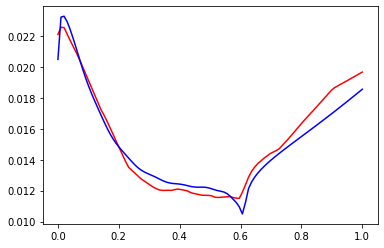

In [135]:
#predict
pre_heldout= forward_model.predict(df_example_1_f.drop(['Reflectance'], axis=1))

plt.plot(df_example_1_f['wavelength'], pre_heldout,'r') 
plt.plot(df_example_1_f['wavelength'], df_example_1_f['Reflectance'], 'b')
plt.show()

### Example 2

In [136]:
#scale
df_example_2_f = df_example_2.copy()
df_example_2_f[['h','top','base','wavelength']] = forward_scaler.transform(df_example_2[['h','top','base','wavelength']])

4/4 [==============================] - 0s 5ms/step


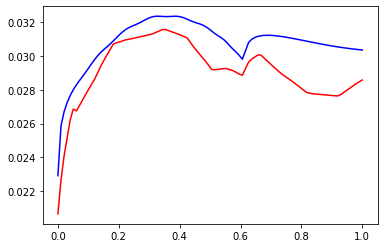

In [137]:
#predict
pre_heldout= forward_model.predict(df_example_2_f.drop(['Reflectance'], axis=1))

plt.plot(df_example_2_f['wavelength'], pre_heldout,'r') 
plt.plot(df_example_2_f['wavelength'], df_example_2_f['Reflectance'], 'b')
plt.show()

## Inverse model inference

In [153]:
#load scaler and model
inverse_scaler = joblib.load('./minmaxscalers/inverse_scaler.save')
inverse_model = keras.models.load_model('./notebooks/models/model_inverse_v4')

### Example 1

In [154]:
df_example_1_i = df_example_1.copy()

In [155]:
#needed preprocess
df_example_1_i = df_example_1_i.groupby(['h','top','base'])
df_example_1_i = df_example_1_i.apply(lambda x: x['Reflectance'].unique())
df_example_1_i = df_example_1_i.reset_index()
df_example_1_i = df_example_1_i.rename(columns= {0: 'Reflectance'})

In [156]:
df_example_1_i

,h,top,base,Reflectance
0,151.0,45.0,60.0,"[0.020490312292858, 0.0232265248745321, 0.0232..."


In [157]:
#predict and scale
extra_X_test = pd.DataFrame(df_example_1_i['Reflectance'].to_list())
pred= inverse_model.predict(extra_X_test)
df_pred_inverse = pd.DataFrame(data=pred, columns=['h','top','base'])
df_pred_inverse = inverse_scaler.inverse_transform(df_pred_inverse)
df_pred_inverse = pd.DataFrame(data=df_pred_inverse, columns=['h','top','base'])

1/1 [==============================] - 0s 105ms/step


In [158]:
print('predicted values:')

predicted values:


In [159]:
df_pred_inverse

,h,top,base
0,147.85463,40.887276,64.093002


In [160]:
print('actual values:')

actual values:


In [161]:
df_example_1_i[['h','top','base']]

,h,top,base
0,151.0,45.0,60.0


### Example 2

In [162]:
df_example_2_i = df_example_2.copy()

In [163]:
#needed preprocess
df_example_2_i = df_example_2_i.groupby(['h','top','base'])
df_example_2_i = df_example_2_i.apply(lambda x: x['Reflectance'].unique())
df_example_2_i = df_example_2_i.reset_index()
df_example_2_i = df_example_2_i.rename(columns= {0: 'Reflectance'})

In [164]:
df_example_2_i

,h,top,base,Reflectance
0,182.0,34.0,50.0,"[0.0229183726180278, 0.0258568333872047, 0.026..."


In [165]:
#predict and scale
extra_X_test = pd.DataFrame(df_example_2_i['Reflectance'].to_list())
pred= inverse_model.predict(extra_X_test)
df_pred_inverse = pd.DataFrame(data=pred, columns=['h','top','base'])
df_pred_inverse = inverse_scaler.inverse_transform(df_pred_inverse)
df_pred_inverse = pd.DataFrame(data=df_pred_inverse, columns=['h','top','base'])

1/1 [==============================] - 0s 33ms/step


In [151]:
print('predicted values:')

predicted values:


In [152]:
df_pred_inverse

,h,top,base
0,197.173508,21.520981,57.660057


In [111]:
print('actual values:')

actual values:


In [113]:
df_example_2_i[['h','top','base']]

,h,top,base
0,182.0,34.0,50.0
